<a href="https://colab.research.google.com/github/boltonotieno/Google-DeepMind-AI-Research-Foundations/blob/main/course_2/gdm_lab_2_5_experiment_with_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> <p><small><small>This Notebook is made available subject to the licence and terms set out in the <a href = "http://www.github.com/google-deepmind/ai-foundations">AI Research Foundations Github README file</a>.

![](https://storage.googleapis.com/dm-educational/assets/ai_foundations/GDM-Labs-banner-image-C2-white-bg.png)

# Lab: Experiment with Embeddings

<a href='https://colab.research.google.com/github/google-deepmind/ai-foundations/blob/master/course_2/gdm_lab_2_5_experiment_with_embeddings.ipynb' target='_parent'><img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Open In Colab'/></a>

Explore how meaning is encoded in the high-dimensional token embeddings of the Gemma language model.

25 minutes

## Overview

In the previous activities, you have recognized that **token embeddings** are high-dimensional vectors. You have also investigated how good embeddings map tokens into this high-dimensional space in such a way that tokens with similar meaning are close together.

In this lab, you will explore these concepts in practice. You will work with embeddings for some of the tokens in Gemma and assess their similarity by computing the **cosine similarity** between pairs of token embeddings. You will also experiment with different methods for visualizing 1,152-dimensional embeddings from the Gemma model in two dimensions.

Working with embeddings (and neural networks, more generally) often involves dealing with vectors and matrices. This lab includes a short introduction to the [`numpy`](https://numpy.org/) package which implements data types and common functions for vectors and matrices.


### What you will learn

By the end of this lab, you will understand:

* How the embedding layer of an LLM (e.g., Gemma) maps tokens to high-dimensional vectors.
* How to work with vectors and matrices in Python using the `numpy` package.
* The geometry of dot products and why cosine similarity captures angle-based semantic closeness.
* The limits of inspecting single embedding dimensions and how dimensionality reduction helps.

### Tasks

In this lab, you will:

* Load a part of the Gemma embedding matrix.
* Implement functions to extract embeddings from the embedding matrix and compute dot products.
* Implement a function that prints similarities for pairs of tokens.
* Visualize individual embedding dimensions.
* Experiment with dimensionality-reduction techniques such as t-SNE.


## How to use Google Colaboratory (Colab)

Google Colaboratory (also known as Google Colab) is a platform that allows you to run Python code in your browser. The code is written in **cells** that are executed on a remote server.

To run a cell, hover over the cell and click on the `run` button to its left. The run button is the circle with the triangle (▶). Alternatively, you can also click on a cell and use the keyboard combination Ctrl+Return (or ⌘+Return if you are using a Mac).

To try this out, run the following cell. This should print today's day of the week below it.

In [ ]:
from datetime import datetime

print(f"Today is {datetime.today():%A}.")

Note that the *order in which you run the cells matters*. When you are working through a lab, make sure to always run *all* cells in order, otherwise the code might not work. If you take a break while working on a lab, Colab may disconnect you and in that case, you have to execute all cells again before  continuing your work. To make this easier, you can select the cell you are currently working on and then choose __Runtime → Run before__  from the menu above (or use the keyboard combination Ctrl/⌘ + F8). This will re-execute all cells before the current one.

## Imports

In this lab, you will primarily work with the `numpy` package (imported as `np`) for working with vectors and matrices. You will also use functions from the custom `ai_foundations` package for visualizing embeddings and performing dimensionality reduction.

Run the following cell to import the required packages.

In [1]:
%%capture
# Install the custom package for this course.
!pip install "git+https://github.com/google-deepmind/ai-foundations.git@main"

import numpy as np # For working with vectors and matrices.
# For loading and projecting embeddings.
from ai_foundations import embeddings as emb
# For providing feedback.
from ai_foundations.feedback.course_2 import embeddings as emb_feedback

## Load Gemma embeddings

As a first step, load the Gemma embeddings for 24 tokens.

You have encountered in one of the previous labs that Gemma's tokenizer uses a vocabulary of more than 260,000 tokens. Its embedding table therefore also has entries for more than 260,000 tokens. To reduce the memory requirements and speed up computations, you will work only with 24 token embeddings in this lab.

Run the following cell to load the embeddings and print the associated list of tokens.

In [2]:
# Load Gemma embeddings.
embeddings, labels = emb.load_gemma_embeddings("https://storage.googleapis.com/dm-educational/assets/ai_foundations/gemma_embeddings.npz")

print(f"The number of tokens are {len(labels)}.")
print(f"The token labels are:\n  {'\n  '.join(labels)}")
print(f"Embeddings {embeddings}")

The number of tokens are 24.
The token labels are:
  king
  queen
  man
  woman
  apple
  banana
  yellow
  red
  rose
  orange
  cat
  dog
  computer
  mobile
  internet
  phone
  car
  bus
  good
  bad
  happy
  sad
  joy
  anger
Embeddings [[ 0.03759766  0.0189209  -0.00167847 ... -0.03979492  0.04052734
  -0.0015564 ]
 [ 0.00021935  0.0090332   0.04199219 ... -0.0090332   0.01245117
   0.00601196]
 [-0.04760742  0.03930664 -0.06176758 ...  0.01953125  0.05859375
  -0.02600098]
 ...
 [ 0.00650024  0.0234375   0.0255127  ... -0.00386047  0.10546875
  -0.06982422]
 [ 0.04833984  0.02294922 -0.01171875 ...  0.00384521  0.00631714
  -0.02148438]
 [ 0.01953125 -0.01049805 -0.01422119 ...  0.02258301  0.02380371
  -0.05078125]]


## Working with matrices and vectors using `numpy`

------
>
> **ℹ️ Info: Vectors and matrices in Python**
>
>The table that stores the embeddings is usually a matrix where each row is a vector that contains the embedding for one token. Before you explore the properties of the Gemma embeddings, explore how you can work with vectors and matrices in Python. This is important for not only working with embeddings but also many other aspects of machine learning, as almost every machine learning model involves a lot of vector and matrix operations.
>
>A vector is in theory just an ordered list of numbers. In theory, you could therefore define vectors as Python lists. Analogously, you could define a matrix as a list of vectors, so a list of lists. However, this would require a lot of steps to perform common vector and matrix operations, such as the dot product or matrix multiplications. In practice, it is therefore a lot more convenient to use the `numpy` package for working with vectors and matrices.
>
>
>By convention, `numpy` is usually imported as `np` as done in the imports above.
>
>```python
>import numpy as np
>```
>
>You can then define vectors and matrices using the `np.array` function:
>
>```python
># Define a 3-dimensional vector `v` with the elements 1 2 3.
>v = np.array([1, 2, 3])
>
># Define a 2x3 dimensional matrix `M` (2 rows, 3 columns) with the following elements:
>#
>#   6 1 4
>#   9 0 2
>#
>M = np.array([[6, 1, 4], [9, 0, 2]])
>```

### Coding Activity 1: Define vectors and matrices

------
> **💻 Your task:**
>
> Define the following vectors and matrices using `np.array`.
>
> $$\mathbf{a} = \begin{pmatrix} 7 \\ 3 \\ 1 \\ 4  \end{pmatrix} \ \ \  \ \ \ \ \mathbf{b} = \begin{pmatrix} 1.5 \\ -2.5 \end{pmatrix} \ \ \ \ \ \ \mathbf{c} = \begin{pmatrix} 4 \\ 4 \\ 4 \end{pmatrix}$$
>
> <br>
> $$P = \begin{pmatrix} 7 & 4\\ 3 & 5 \\ 1 & 6 \\ 4 & 7  \end{pmatrix} \ \ \  \ \ \ \ Q = \begin{pmatrix} 7 & 3 & 1 & 4 \\ 4 & 5 & 6 & 7 \end{pmatrix} \ \ \ \ \ \ R = \begin{pmatrix} 4 & 4 & 4 \end{pmatrix}$$
-----




In [4]:
a = np.array([7, 3, 1, 4])
b = np.array([1.5, -2.5])
c = np.array([4, 4, 4])

P = np.array([[7, 4], [3, 5], [1, 6], [4, 7]])
Q = np.array([[7, 3, 1, 4], [4, 5, 6, 7]])
R = np.array([[4, 4, 4]])

In [5]:
# @title Run this cell to test your code
emb_feedback.test_numpy_arrays(a, b, c, P, Q, R)

✅ Nice! Your answer looks correct.


### Coding Activity 2: The shape of vectors and matrices

When working with vectors and matrices, you will often need to determine their **shape**. The shape is the dimension of a vector or a matrix. For vectors, this is the number of elements in the vector. For matrices this is the number of rows and columns in the matrix.

You can get the shape of a numpy array using the `.shape` property. This returns a tuple with the number of rows and the number of columns (if it is a matrix).

Run the following cell to print the vectors and matrices that you defined above along with their shapes.

In [6]:
print(f"a = {a}")
print(f"Shape of a: {a.shape}")
print("-" * 20)

print(f"b = {b}")
print(f"Shape of b: {b.shape}")
print("-" * 20)

print(f"c = {c}")
print(f"Shape of c: {c.shape}")
print("-" * 20)

print(f"P =\n{P}")
print(f"Shape of P: {P.shape}")
print("-" * 20)

print(f"Q =\n{Q}")
print(f"Shape of Q: {Q.shape}")
print("-" * 20)

print(f"R =\n{R}")
print(f"Shape of R: {R.shape}")

a = [7 3 1 4]
Shape of a: (4,)
--------------------
b = [ 1.5 -2.5]
Shape of b: (2,)
--------------------
c = [4 4 4]
Shape of c: (3,)
--------------------
P =
[[7 4]
 [3 5]
 [1 6]
 [4 7]]
Shape of P: (4, 2)
--------------------
Q =
[[7 3 1 4]
 [4 5 6 7]]
Shape of Q: (2, 4)
--------------------
R =
[[4 4 4]]
Shape of R: (1, 3)


------
> **💻 Your task:**
>
> Complete the following cell to compute the dimension of each token embedding in `embeddings`.
>
> Hint: The dimension of each vector is the number of columns in the `embeddings` matrix.
>
------

In [7]:
embedding_dim = embeddings.shape[1]

print(f"Dimension of Gemma embeddings: {embedding_dim:,}")

Dimension of Gemma embeddings: 1,152


In [8]:
# @title Run this cell to test your code
emb_feedback.test_embedding_dimension(embedding_dim, embeddings)

✅ Excellent! You've correctly extracted the embedding dimension.


### Coding Activity 3: Access rows and columns

One advantage of working with `numpy` arrays is that you can easily access individual rows or columns of the matrix.

To access parts of a matrix `M`, you can use angled brackets, like you would with lists:

```python
M[row_or_rows, column_or_columns]
```

If you want all rows or all columns, you can use the placeholder `:`.

For example, the following code accesses all columns of the 3rd row  of the matrix `M`:

```python
M[2, :]
```

The following code accesses all rows of the 4th column of `M`:

```python
M[:, 3]
```

Note, that as usual in Python, the first row and column has the index 0.

<br />

------
> **💻 Your task:**
>
> Access the third row (index 2) and the seventh column (index 6) from `embeddings`.
------

In [13]:
third_row = embeddings[2, :]
seventh_column = embeddings[:, 6]

print(f"Shape of third_row: {third_row.shape}")
print(f"Shape of seventh_column: {seventh_column.shape}")

Shape of third_row: (1152,)
Shape of seventh_column: (24,)


In [14]:
# @title Run this cell to test your code
emb_feedback.test_numpy_slicing(third_row, seventh_column, embeddings)

✅ Nice! Your answer looks correct.


### Coding Activity 4: Dot product

The dot product is one of the most common operations you will use in machine learning. This product (also called the inner product in this context) between $K$-dimensional vectors $\mathbf{u} \in \mathbb{R}^K$ and $\mathbf{v} \in \mathbb{R}^K$ is defined as:

$$
\mathbf{u} \cdot \mathbf{v} = \sum_{k=1}^K u_k v_k
\;=\;
u_1 v_1 + u_2 v_2 + \cdots + u_K v_K $$


It is also sometimes written as $\mathbf{u}^T \mathbf{v}$. The superscript ${}^T$ indicates that the vector should be transposed, that is, a column vector should be transformed into a row vector.

In Python, you can compute the dot product between the vectors `u` and `v` using either the `np.dot` function, or the more general  `np.matmul` function that is used to multiply matrices:

```python
dot_product = np.dot(u, v)

dot_product = np.matmul(u.T, v)
```

Note that if you use matmul, you have to make sure that the second dimension of the first argument and the first dimension of the second argument agree. This may involve computing the transpose, which is done here using `u.T`.

<br />

------
> **💻 Your task:**
>
> Complete the following cell to compute the dot product between the third row (index 2) and the fourth row (index 3) of `embeddings`.
>
------


In [16]:
third_row = embeddings[2, :]
fourth_row = embeddings[3, :]

dot_product = np.dot(third_row, fourth_row)

print(f"Dot product: {dot_product:.4f}")

Dot product: 0.4967


In [17]:
# @title Run this cell to test your code
emb_feedback.test_dot_product(dot_product, embeddings)

✅ Nice! Your answer looks correct.




In the context of embeddings, the dot product is an important measure of similarity:


![](https://storage.googleapis.com/dm-educational/assets/ai_foundations/inner-products.png)

* If the dot product is negative, that is, when $\mathbf{u}^T \mathbf{v} < 0$, the angle between them is bigger than 90 degrees. This means that the two vectors are pointing in opposite directions and this indicates a high level of dissimilarity.

* If the dot product between two embeddings is zero, that is, when $\mathbf{u}^T \mathbf{v} = 0$, they are orthogonal and the angle between them is 90 degrees. This means that, loosely speaking, the embeddings are unrelated.

* If the dot product is positive, that is, when $\mathbf{u}^T \mathbf{v} > 0$, the angle between them is less than 90 degrees. This means that the vectors are pointing in a similar direction and this indicates that the embeddings are similar.

When you placed the embeddings for "apple" and "banana" on a 2D plane, you most likely placed them so that the angle between the two embeddings is small, and intuitively placed them so that $\mathbf{u}^T \mathbf{v} > 0$.

## Cosine similarity

While the dot product by itself already indicates the similarity of two embeddings, it can become very big or very small when a vector has many dimensions. This is because you are summing over a lot of values. To make the similarities less dependent on the specific values and the number of dimensions, it can be useful to **normalize** the similarity such that it always returns a value between -1 and +1.

The **cosine similarity** does exactly that:

$$
\text{cosine}\ \bigl(\mathbf{u},\mathbf{v}\bigr)
\;=\;
\frac{\mathbf{u}\,\cdot\,\mathbf{v}}
     {\lVert \mathbf{u} \rVert \,\lVert \mathbf{v} \rVert}
$$

where $\mathbf{u}\cdot\mathbf{v}$ is the dot product of the two vectors, and ${\lVert \mathbf{u} \rVert \,\lVert \mathbf{v} \rVert}$
are the magnitudes (lengths) of the vectors $\mathbf{u}$ and $\mathbf{v}$, respectively.

As you can observe in the formula, the cosine similarity measures how similar two vectors are by computing the dot product between them, scaled by their lengths. This captures the cosine of the angle between them rather than their magnitude.

The cosine similarity is +1 for identical directions, 0 for orthogonal vectors (e.g., embeddings of unrelated tokens), and -1 for opposite vectors (e.g., embeddings of strong antonyms).

Run the following cell to define a function that computes the cosine similarity between two vectors.

In [18]:
def cos_sim(u: np.ndarray, v: np.ndarray) -> float:
    """Computes the cosine similarity between two 1-D numpy arrays u and v.

    Args:
      u: A vector of dimension (k,).
      v: A vector of dimension (k,).

    Returns:
      The dot product between u and v.
    """

    dot_uv = np.matmul(u.T,v)

    # np.linalg.norm(u, 2) computes the length of the vector u (its L2-norm).
    len_u = np.linalg.norm(u, 2)
    len_v = np.linalg.norm(v, 2)

    # u . v / (||u|| * ||v||).
    cosine_sim = dot_uv / (len_u * len_v)

    # Turn 1x1 numpy array into a float.
    cosine_sim = cosine_sim.item()

    return cosine_sim

### Coding Activity 5: Access the embedding for a token

Before you can compute the cosine similarity between two token embeddings, you need to write a function that returns the embedding for a specific token, e.g., "apple".

For this you need to determine the index of the token in the embedding matrix. The list `labels` that was loaded at the top of this lab contains all tokens with corresponding embeddings in `embeddings`. The embedding of the first element in the list is the first row of `embeddings`, the embedding of the second element in the list is the second `embedding`, etc.

To determine the index of the embedding, you can use the `.index` method of the list. For example, `labels.index("apple")` returns the index of the row of the embedding for "apple".

<br />

------
> **💻 Your task:**
>
> Complete the function `get_embedding(token)` in the cell below.
>
> It should look up the index of the token in `labels` and then return the token embedding for `token`.
>
------

In [19]:
def get_embedding(
    token: str, embeddings: np.ndarray = embeddings, labels: list[str] = labels
) -> np.ndarray:
    """Returns the embedding for `token` from `embeddings`.

    Args:
      token: The token for which the embedding should be retrieved.
      embeddings: The embedding matrix with embeddings for all tokens in
        `labels`.
      labels: The list of tokens indicating the order of embeddings in
        `embeddings`.

    Returns:
      The token embedding (a vector) for `token`.

    Raises:
      ValueError if no embeddings for `token` exists.
    """

    if token not in labels:
        raise ValueError(f"No embeddings for {token} exist.")

    token_idx =  labels.index(token)
    embedding =  embeddings[token_idx]

    return embedding


In [20]:
# @title Run this cell to test your code
emb_feedback.test_get_embedding(get_embedding, embeddings, labels)

✅ Nice! Your answer looks correct.


### Coding Activity 6: Compute the cosine similarity

You will now use the implementation of `cos_sim` to define a function that prints the similarity between the embeddings of two tokens.

<br />

------
> **💻 Your task:**
>
> Complete the function `print_similarity` below.
>
> It should use your implementation of `get_embedding` to retrieve the embeddings for `token1` and `token2`, and use the implementation of `cos_sim` above to compute the cosine similarity.
>
------

In [29]:
def print_similarity(
    token1: str,
    token2: str,
    embeddings: np.ndarray = embeddings,
    labels: list[str] = labels,
) -> float:
    """
    Computes and prints the cosine similarity between the embeddings of `token1`
      and `token2`.

    Args:
      token1: The first token for the similarity computation.
      token2: The second token for the similarity computation.
      embeddings: The embedding matrix with embeddings for `token1` and
        `token2`.
      labels: The list of tokens indicating the order of embeddings in
        `embeddings`.

    Returns:
      The cosine similarity between `token1` and `token2`.

    Raises:
      ValueError if no embedding for `token1` or `token2` exists.

    """

    embedding1 = get_embedding(token1, embeddings, labels)
    embedding2 = get_embedding(token2, embeddings, labels)

    similarity = cos_sim(embedding1, embedding2)
    print(
        f'Cosine similarity between "{token1}" and "{token2}" '
        f'\t= {similarity:.2f}'
    )
    return similarity

In [30]:
# @title Run this cell to test your code
emb_feedback.test_print_similarity(print_similarity, get_embedding, cos_sim, embeddings, labels)

Cosine similarity between "queen" and "joy" 	= 0.12
✅ Nice! Your answer looks correct.


You can now use this function to compute the similarity between pairs of tokens.

In [31]:
print_similarity("king", "king")
print_similarity("king", "queen")
print_similarity("queen", "king")
print_similarity("joy", "happy")
print_similarity("good", "bad")
print_similarity("sad", "happy")
print_similarity("king", "bus")
print_similarity("car", "banana")
print()

Cosine similarity between "king" and "king" 	= 1.00
Cosine similarity between "king" and "queen" 	= 0.42
Cosine similarity between "queen" and "king" 	= 0.42
Cosine similarity between "joy" and "happy" 	= 0.29
Cosine similarity between "good" and "bad" 	= 0.42
Cosine similarity between "sad" and "happy" 	= 0.22
Cosine similarity between "king" and "bus" 	= 0.04
Cosine similarity between "car" and "banana" 	= 0.07



#### What did you observe?

In the embedding space of a well-trained model such as Gemma, you expect to see similarities between closely related tokens to be high. This is the case here, for example the similarity between "king" and "queen" is 0.42. This indicates that the model has learned that these two tokens should be embedded close together and should have a high semantic similarity. Also note how the cosine similarity is symmetric. The similarity between "king" and "queen" and the similarity between "queen" and "king" is exactly the same.

The cosine similarity between entirely unrelated tokens tends to be low. For example, the similarity between "king" and "bus" is 0.04, indicating that according to the model's embedding space, these tokens are unrelated.

The comparably high similarity of some of the antonyms (e.g., `cosine(sad, happy) = 0.22` or `cosine(good, bad) = 0.42`) is potentially a bit more surprising. However, even though the token pairs have opposite meanings, they are still pairs of adjectives that describe similar concepts (i.e., feelings or quality).

## Visualizing embeddings

You will now turn to visualizing embeddings. As mentioned, the Gemma 1B model uses 1,152-dimensional embeddings. While it is straightforward to visualize two or maybe even three dimensions, visualizing a 1,152-dimensional space presents a challenge.

In this part of the lab, you will explore different methods for visualizing these high-dimensional embeddings.

### Visualizing individual dimensions

The cell below visualizes individual dimensions of token embeddings by choosing two dimensions. For each token, this method extracts only two elements of its vector (the dimensions specified by you) and then plots the tokens in this two-dimensional space.

Use the sliders below to choose different combinations of dimensions and run the cell each time to plot these two dimensions.




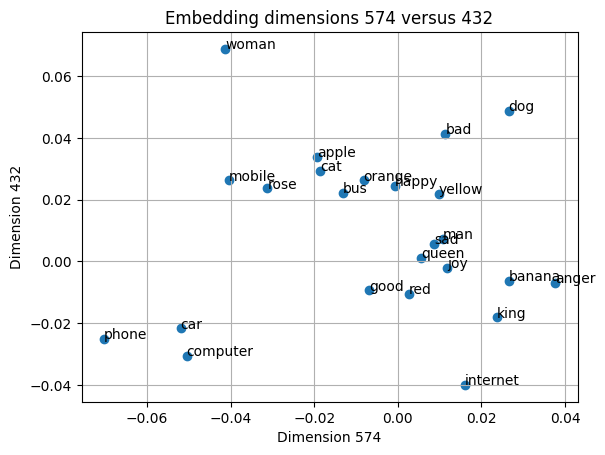

In [38]:
# @title Plot individual dimensions
dimension_1 = 574  #@param {type: 'slider', min:0, max:1151}
dimension_2 = 432  #@param {type: 'slider', min:0, max:1151}
emb.plot_embeddings_dimensions(embeddings,
                           labels,
                           dim_x=dimension_1,
                           dim_y=dimension_2)

#### What did you observe?

You likely found that it was difficult to find any pairs of dimensions in which clear clusters emerged. It was likely also difficult to find interpretations for the dimensions. Sometimes, one dimension may have put tokens with similar functions (e.g., nouns) closer together whereas other times, it may have put tokens with related meanings (e.g., "banana" and "yellow") closer together.

In the next activity, you will use a more sophisticated dimensionality reduction technique that considers all the information in the high-dimensional embeddings.

### Visualizing  embeddings with t-SNE

As you likely observed in the previous activity, it is not easy to see patterns by visualizing any two Gemma embeddings against each other. This is because meaningful word relationships typically arise from combinations of many embedding dimensions. As you are only able to visualize two or three dimensions at a time, this method did not allow you to capture the full complexity of the embedding space.

To make the high-dimensional embedding space more interpretable, dimensionality reduction techniques can be of great help. Rather than naively picking two or three dimensions, these techniques try to compress the embedding space into fewer dimensions with the goal of capturing as much information as possible from the original embedding space.

One such technique is [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). This technique has been particularly well-suited for projecting embeddings for visualizations. t-SNE is a visualization method that **preserves the pairwise similarities** between data points in a lower-dimensional space. This gives you an "at a glance" map of the neighbourhoods hidden in the high dimensional space: the algorithm keeps local distances faithful, so clusters that are closely related pop out as tight clouds that are easy to label and debug.

You are then able to use these 2D points to generate a visualization that gives you an intuitive sense of how the words are distributed in the high-dimensional space. Data points close together in the high-dimensional space will appear closer together in 2D using t-SNE.

Run the following cell to generate an t-SNE plot of the 22 tokens that you have been considering in this activity.

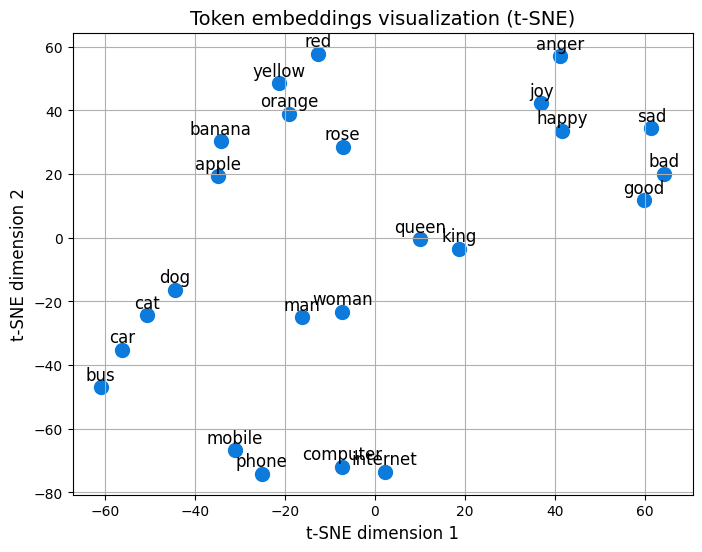

In [39]:
emb.plot_embeddings_tsne(embeddings, labels)

#### What did you observe?

The plot above shows that many tokens with similar meanings are close together in the vector space. For example, there is a cluster of the tokens "mobile", "phone", "computer", and "internet". Similarly, "man" and "woman" as well as "queen" and "king" are close together.

At the same time, some tokens, such as "cat" and "car" that do not have much in common are also close together. This is likely largely a result of the dimensionality reduction. By projecting the embeddings to a 2-dimensional space, you lose some fine-grained information and while it correctly projects the embeddings "cat" and "dog" close together, there are also artifacts such as the proximity between the embeddings of "cat" and "car".

Recall when you manually put some of these tokens in a 2D grid. Did you end up with a similar arrangement to this? Which dimensions of meaning do you think are encoded in this plot?

## Summary

In this lab, you explored the **high-dimensional token embeddings** of the Gemma model using the `numpy` library to perform vector and matrix operations. You implemented **cosine similarity** to mathematically measure the "closeness" of tokens, confirming that words with similar meanings (like "king" and "queen") are located near each other in the embedding space. You then discovered the challenge of **visualizing** these vectors, finding that plotting individual dimensions directly revealed little about the overall structure. Finally, by using a **dimensionality reduction technique** called t-SNE, you successfully projected the embeddings into 2D and observed how the model organized words into meaningful **semantic clusters**, grouping related concepts together.

## Solutions


The following cells provide reference solutions to the coding activities in this notebook. If you really get stuck after trying to solve the activities yourself, you may want to consult these solutions.


It is recommended that you *only* look at the solutions after you have tried to solve the activities *multiple times*. The best way to learn challenging concepts in computer science and artificial intelligence is to debug your code piece-by-piece until it works, rather than copying existing solutions.


If you feel stuck, you may want to first try to debug your code. For example, by adding additional print statements to see what your code is doing at every step. This will provide you with a much deeper understanding of the code and the materials. It will also provide you with practice on how to solve challenging coding problems beyond this course.

To view the solutions for an activity, click on the arrow to the left of the activity name. If you consult the solutions, do not copy and paste them into the cells above. Instead, look at them, and type them manually into the cell. This will help you understand where you went wrong.


### Coding Activity 1

In [ ]:
# Copy these solutions into the cell above.
a = np.array([7, 3, 1, 4])
b = np.array([1.5, -2.5])
c = np.array([4, 4, 4])

P = np.array([[7, 4], [3, 5], [1, 6], [4, 7]])
Q = np.array([[7, 3, 1, 4], [4, 5, 6, 7]])
R = np.array([[4, 4, 4]])

### Coding Activity 2

In [40]:
embedding_dim = embeddings.shape[1]

### Coding Activity 3

In [41]:
third_row = embeddings[2, :]
seventh_column = embeddings[:, 6]

### Coding Activity 4

In [42]:
third_row = embeddings[2,:]
fourth_row = embeddings[3,:]

dot_product = np.matmul(third_row.T, fourth_row)

### Coding Activity 5

In [43]:
# Complete implementation of get_embedding.
def get_embedding(
    token: str, embeddings: np.ndarray = embeddings, labels: list[str] = labels
) -> np.ndarray:
    """Returns the embedding for token from embeddings.

    Args:
      token: The token for which the embedding should be retrieved.
      embeddings: The embedding matrix with embeddings for all tokens in `labels`.
      labels: The list of tokens indicating the order of embeddings in
        `embeddings`.

    Returns:
      The token embedding (a vector) for `token`.

    Raises:
      ValueError if no embedding for `token` exists.
    """

    if token not in labels:
        raise ValueError(f"No embeddings for {token} exist.")

    token_idx = labels.index(token)
    embedding = embeddings[token_idx, :]

    return embedding


### Coding Activity 6

In [44]:
# Complete implementation of print_similarity.
def print_similarity(
    token1: str,
    token2: str,
    embeddings: np.ndarray = embeddings,
    labels: list[str] = labels,
) -> float:
    """
    Computes and prints the cosine similarity between the embeddings of `token1`
      and `token2`.

    Args:
      token1: The first token for the similarity computation.
      token2: The second token for the similarity computation.
      embeddings: The embedding matrix with embeddings for `token1` and `token2`.
      labels: The list of tokens indicating the order of embeddings in
        `embeddings`.

    Returns:
      The cosine similarity between `token1` and `token2`.

    Raises:
      ValueError if no embedding for `token1` or `token2` exists.

    """

    embedding1 = get_embedding(token1, embeddings, labels)
    embedding2 = get_embedding(token2, embeddings, labels)

    similarity = cos_sim(embedding1, embedding2)
    print(f'Cosine similarity between "{token1}" and "{token2}"  \t= {similarity:.2f}')
    return similarity
